In [526]:
import numpy as np
import matplotlib.pyplot as plt

In [527]:
np.random.seed(0)

## Preparation

Let's first create a simple distribution $p(y|x)$. We shall use a simple model
$$
p(y|x) = \mathcal{N}(y|\sin(\pi x), 0.01).
$$
In other words, the distribution is a Gaussian centered around $\mu = \sin (\pi x)$ with variance $\sigma^2 = 0.01$.

In [528]:
# create the data
N = 8
mu = lambda x : np.sin(2*np.pi * x)
X = np.linspace(0,1,N)
Y = mu(X) + np.random.normal(scale=0.1, size=N)


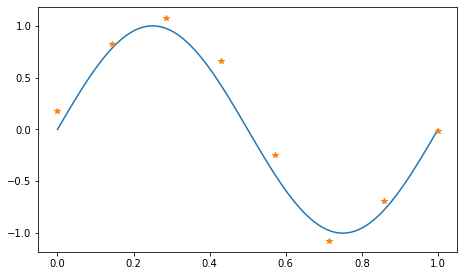

In [529]:
# plot the data vs. the mean
plt.gcf().set_size_inches(7.5, 4.5)
grid = np.linspace(0,1,100)
plt.plot(grid,mu(grid));
plt.plot(X,Y,'*');

## Gaussian Process Regression

Let's perform the actual regression. We assume that the data follows the Gaussian process prior
$$
y \sim GP(m(x), k(x, x')),
$$
where $m(x)$ is the mean and $k(x,x')$ is some prescribed Kernel.

In [530]:
# kernel = "RBF" # or polynomial
# if kernel == "RBF":
#   def K(x, xp):
#     alpha = 10.0
#     beta = 0.02
#     gamma = 0.5
#     return 1/alpha * np.exp(- 0.5 * beta * np.linalg.norm(x-xp) ** 2) + gamma * x.T @ xp
# elif kernel == "polynomial":
#   def K(x, xp):
#     alpha = 10.0
#     p = 4
#     phi = np.array([x**n for n in range(0,p)])
#     phip = np.array([xp**n for n in range(0,p)])
#     return 1/alpha * phi.T @ phip

We start with a simple Kernel which is equivalent to a polynomial fit.

In [531]:
def K(x, xp, alpha=1e+3):
  p = 12
  phi = np.array([x**n for n in range(0,p)])
  phip = np.array([xp**n for n in range(0,p)])
  return alpha * phi.T @ phip

In [532]:
# time to make a prediction
alpha = 100.

xp = np.linspace(0,1,100)
A = K(X, X) + np.eye(N) / alpha
B = K(X, xp)
C = K(xp, xp)

# the resulting distribution is
m = B.T @ np.linalg.solve(A, Y)
S = C - B.T @ np.linalg.solve(A, B)

# compute the resulting variance
sigma = np.sqrt(np.diag(S))

Let's plot the function:

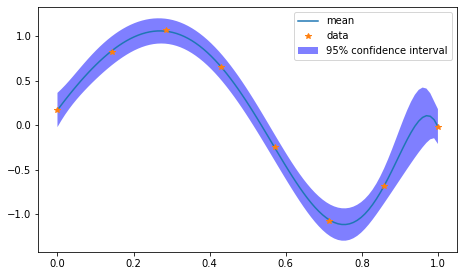

In [533]:
# plot the posterior Gaussian Process
plt.gcf().set_size_inches(7.5, 4.5)
plt.plot(xp, m, label="mean");
plt.fill_between(xp, m-1.9600*sigma, m+1.9600*sigma, alpha=0.5, fc="b", ec="None", label="95% confidence interval")
plt.plot(X,Y,'*', label="data");
plt.legend()
plt.show()

Encouragingly, the mean looks exactly like a polynomial fit going through all the points. Interestingly, the variance in each point is essentially $0$, which is to be expected as there is no unvertainty in the polynomial fit.

Another interesting behavior is observed when the polynomial degree is lowered below the number of points. Feel free to try it out!

Let us now experiment with some other Kernel functions. We will use the radial basis function kernel
$$
K(x, x') = \alpha \exp\left(- \frac{||x-x'||^2}{2 \beta^2}\right)
$$

In [534]:
def K(x, xp, alpha=1e+0, beta=1e+2):
    dist = (np.outer(x, np.ones_like(xp)) - np.outer(np.ones_like(x), xp)) ** 2 # assume we have points
    return alpha * np.exp(- 0.5 * dist * beta)

We can visualize the kernel $K$ evaluated on a grid:

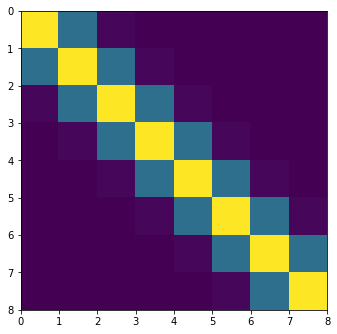

In [535]:
# dist = (np.outer(X, np.ones_like(X)) - np.outer(np.ones_like(X), X)) ** 2
plt.gcf().set_size_inches(5.5, 5.5)
plt.pcolor(K(X,X))
ax = plt.gca()
ax.invert_yaxis()
plt.show()

let's take this new Kernel for a spin.

In [536]:
# time to make a prediction
alpha = 100.

xp = np.linspace(0,1,100)
A = K(X, X) + np.eye(N) / alpha
B = K(X, xp)
C = K(xp, xp)

# the resulting distribution is
m = B.T @ np.linalg.solve(A, Y)
S = C - B.T @ np.linalg.solve(A, B)

# compute the resulting variance
var = np.diag(S);

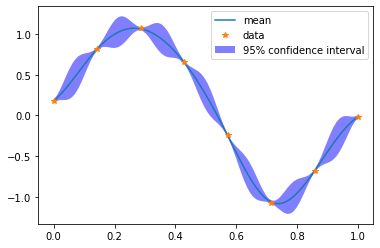

In [537]:
# plot the posterior Gaussian Process
plt.plot(xp, m, label="mean");
plt.fill_between(xp, m-1.9600*var, m+1.9600*var, alpha=0.5, fc="b", ec="None", label="95% confidence interval")
plt.plot(X,Y,'*', label="data");
plt.legend()
plt.show()